<a href="https://colab.research.google.com/github/lokeshpara/samplegit/blob/S6/eva_session_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Sequential(nn.Conv2d(1,16,3,padding=0,bias=False),        #conv1  1 input , 16 0utput and 3x3 kernel
                                 nn.ReLU(),                                     #RF:3
                                 nn.BatchNorm2d(16),                            #o/p:26
                                 nn.Dropout2d(0.04))
        
        
        self.conv2=nn.Sequential(nn.Conv2d(16,32,3,padding=0,bias=False),       #conv2  16 input , 32 0utput and 3x3 kernel
                                 nn.ReLU(),                                     #RF:5
                                 nn.BatchNorm2d(32),                            #o/p:24
                                 nn.Dropout2d(0.04))
        



        # used 1x1 kernel 
        self.conv3=nn.Sequential(nn.Conv2d(32,8,1,bias=False))                  #conv3  32 input , 8 0utput and 1x1 kernel 
                                                                                #RF:5
                                                                                #o/p:24
        


        self.maxpool=nn.MaxPool2d(2,2)                                          # maxpooling 2x2 kernel and stride 2
                                                                                #RF:6
                                                                                #o/p:12


     

        self.conv4=nn.Sequential(nn.Conv2d(8,14,3,padding=0,bias=False),        #conv4  8 input , 14 0utput and 3x3 kernel
                                 nn.ReLU(),                                     #RF:10
                                 nn.BatchNorm2d(14),                            #o/p:10
                                 nn.Dropout2d(0.04))
                                                                                
        
        self.conv5=nn.Sequential(nn.Conv2d(14,16,3,padding=0,bias=False),       #conv5  14 input , 16 0utput and 3x3 kernel
                                 nn.ReLU(),                                     #RF:14
                                 nn.BatchNorm2d(16),                            #o/p:8
                                 nn.Dropout2d(0.04))                                                
                                                                                
                                                                
        
        #self.maxpool=nn.MaxPool2d(2,2)
                                                               
        self.conv6=nn.Sequential(nn.Conv2d(16,10,1,padding=0,bias=False))       #conv6  16 input , 10 0utput and 3x3 kernel
                                                                                #RF:14
                                                                                #o/p:8
                                                                                

        self.conv7=nn.Sequential(nn.Conv2d(10,16,3,padding=0,bias=False),
                                 nn.ReLU(),                                     #conv6  10 input , 16 0utput and 3x3 kernel
                                 nn.BatchNorm2d(16),                            #RF:18
                                 nn.Dropout2d(0.04))                            #o/p:6           
                                                                                
        
        self.GAP=nn.AvgPool2d(6)                                                # Gobal Average Pooling 
                                                                                #RF:28
                                                                                #o/p:1

                                                                                

        self.conv8 = nn.Sequential(nn.Conv2d(16,10,1, padding=0, bias=False))   #RF:28
                                                                                #O/P:1                                           
                                                                                


             
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        #x=self.maxpool(x)
        x=self.conv3(x)
        x=self.maxpool(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #x=self.maxpool(x)
        x=self.conv6(x)
        x=self.conv7(x)
        x=self.GAP(x)
        x=self.conv8(x)
        x=x.view(-1,10)
        return F.log_softmax(x)


!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
         Dropout2d-8           [-1, 32, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             256
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,008
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
        Dropout2d-14           [-1, 14,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = [[],[],[],[]]
train_acc = []
test_acc = [[],[],[],[]]

def train(model, device, train_loader, optimizer, epoch, l1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # L1
    if l1 == True:
      reg_loss = 0
      for param in model.parameters():
        reg_loss += torch.sum(abs(param))
      factor = 0.000002
      loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,num=0):
  
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[num].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[num].append(100. * correct / len(test_loader.dataset))

## Without L1 and L2

In [41]:
from torch.optim.lr_scheduler import StepLR

model_1 =  Net().to(device)
optimizer = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9, weight_decay=0)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_1, device, train_loader, optimizer, epoch, l1 = False)
    # scheduler.step()
    test(model_1, device, test_loader,num=0)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.15895026922225952 Batch_id=468 Accuracy=84.80: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0946, Accuracy: 9741/10000 (97.41%)

EPOCH: 1


Loss=0.169788658618927 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:14<00:00, 31.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0649, Accuracy: 9823/10000 (98.23%)

EPOCH: 2


Loss=0.07671777158975601 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:14<00:00, 38.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.1488797515630722 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.025055624544620514 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.020197317004203796 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.03468328341841698 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.04929304122924805 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.027749409899115562 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.06821506470441818 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.0371437631547451 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.06857471168041229 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.06607924401760101 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 37.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.0824228972196579 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.013412575237452984 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.058908965438604355 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 16


Loss=0.03252652287483215 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


Loss=0.028726665303111076 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.0632389709353447 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.009945814497768879 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 20


Loss=0.04798878729343414 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 21


Loss=0.08947787433862686 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

EPOCH: 22


Loss=0.07078911364078522 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.019081756472587585 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 24


Loss=0.027262717485427856 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 25


Loss=0.011726086027920246 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 30.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9932/10000 (99.32%)

EPOCH: 26


Loss=0.04743092134594917 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9947/10000 (99.47%)

EPOCH: 27


Loss=0.02015707455575466 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 29.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9928/10000 (99.28%)

EPOCH: 28


Loss=0.057260025292634964 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 29


Loss=0.006788407918065786 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

EPOCH: 30


Loss=0.03229832649230957 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9937/10000 (99.37%)

EPOCH: 31


Loss=0.013178701512515545 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9933/10000 (99.33%)

EPOCH: 32


Loss=0.008142799139022827 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 34.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9928/10000 (99.28%)

EPOCH: 33


Loss=0.013191625475883484 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 35.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)

EPOCH: 34


Loss=0.03385258838534355 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9930/10000 (99.30%)

EPOCH: 35


Loss=0.03998176380991936 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

EPOCH: 36


Loss=0.007900185883045197 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 37


Loss=0.05727061629295349 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)

EPOCH: 38


Loss=0.02739558182656765 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

EPOCH: 39


Loss=0.05605436488986015 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]



Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)



In [0]:
my_misclassified_images = torch.rand(25,28,28) * 0
ground_truth = torch.rand(25,1)*0
classified_lie = torch.rand(25,1)*0
num_false_images = 0

def mis_classified(model, device, test_loader):
    global num_false_images
    global ground_truth
    global classified_lie
    
    model.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            false_picker = torch.flatten(pred)-target
            index = 0
            for val in false_picker:
                if (val != 0):
                    my_misclassified_images[num_false_images] = data[index, 0, :, :]
                    ground_truth[num_false_images] = target[index]
                    classified_lie[num_false_images] = pred[index]
                    num_false_images = num_false_images + 1
                    if (num_false_images >= 25): 
                        break

                index = index + 1
               
            if (num_false_images >= 25):
                  break

## With L1 Regularization 

In [17]:
from torch.optim.lr_scheduler import StepLR

model_2 =  Net().to(device)
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9, weight_decay=0)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_2, device, train_loader, optimizer, epoch, l1=True)
    # scheduler.step()
    test(model_2, device, test_loader, num=1)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.22569410502910614 Batch_id=468 Accuracy=84.64: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1103, Accuracy: 9716/10000 (97.16%)

EPOCH: 1


Loss=0.09995193034410477 Batch_id=468 Accuracy=96.52: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9852/10000 (98.52%)

EPOCH: 2


Loss=0.10411801189184189 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.10648699849843979 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.052070826292037964 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.023649251088500023 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.08352137356996536 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.06556057929992676 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 29.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.01728213205933571 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.06002718582749367 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.08182012289762497 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.10255522280931473 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.11321893334388733 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.018507231026887894 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.06552550196647644 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.04267783835530281 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9924/10000 (99.24%)

EPOCH: 16


Loss=0.005858288146555424 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 39.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.08435865491628647 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.01607317104935646 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.034225381910800934 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Loss=0.021911073476076126 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.06281797587871552 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.03262171894311905 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Loss=0.016057081520557404 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.040460310876369476 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9932/10000 (99.32%)

EPOCH: 25


Loss=0.02053510956466198 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

EPOCH: 26


Loss=0.015188218094408512 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

EPOCH: 27


Loss=0.01298705954104662 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9946/10000 (99.46%)

EPOCH: 28


Loss=0.014235897921025753 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9925/10000 (99.25%)

EPOCH: 29


Loss=0.013988016173243523 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)

EPOCH: 30


Loss=0.02510088123381138 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

EPOCH: 31


Loss=0.03879433125257492 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 34.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9933/10000 (99.33%)

EPOCH: 32


Loss=0.013026479631662369 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 33


Loss=0.04433112591505051 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.004589887335896492 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 35


Loss=0.03701837360858917 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9939/10000 (99.39%)

EPOCH: 36


Loss=0.010412572883069515 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9940/10000 (99.40%)

EPOCH: 37


Loss=0.028674433007836342 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 37.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

EPOCH: 38


Loss=0.016186939552426338 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 39


Loss=0.01435190998017788 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]



Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)



## Misclassified image of L1 Regularization

In [18]:
mis_classified(model_2, device, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


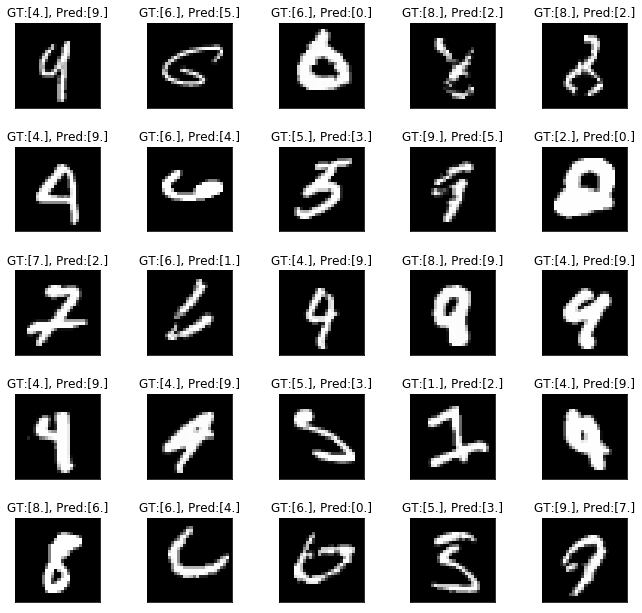

In [19]:


num_img_rows = 5
num_img_cols = 5

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(my_misclassified_images[i,:,:], cmap='gray', interpolation='none')
  plt.title("GT:{}, Pred:{}".format(ground_truth[i].numpy(), classified_lie[i].numpy()))
  plt.xticks([])
  plt.yticks([])

## With L2 Regularization

In [20]:
from torch.optim.lr_scheduler import StepLR

model_3 =  Net().to(device)
optimizer = optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000005)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_3, device, train_loader, optimizer, epoch, l1 = False)
    # scheduler.step()
    test(model_3, device, test_loader, num=2)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.1571294665336609 Batch_id=468 Accuracy=84.75: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1028, Accuracy: 9735/10000 (97.35%)

EPOCH: 1


Loss=0.14174117147922516 Batch_id=468 Accuracy=96.39: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0614, Accuracy: 9828/10000 (98.28%)

EPOCH: 2


Loss=0.07710833847522736 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.05118789151310921 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.04934876784682274 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.10265500098466873 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.030657276511192322 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.05390312895178795 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.06276384741067886 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 31.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.04902377724647522 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.023465460166335106 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.03417788818478584 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.03136320039629936 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.10176640748977661 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.01807366870343685 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 31.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.0040182569064199924 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9924/10000 (99.24%)

EPOCH: 16


Loss=0.028937675058841705 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9903/10000 (99.03%)

EPOCH: 17


Loss=0.0162948090583086 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.006389195565134287 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.0514989010989666 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.005593965295702219 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.0337349958717823 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.061821043491363525 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 23


Loss=0.00727073336020112 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.02391429804265499 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)

EPOCH: 25


Loss=0.01879424788057804 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)

EPOCH: 26


Loss=0.0631789118051529 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 27


Loss=0.015467162244021893 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

EPOCH: 28


Loss=0.006997788790613413 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

EPOCH: 29


Loss=0.021304572001099586 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9931/10000 (99.31%)

EPOCH: 30


Loss=0.01302353572100401 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 31


Loss=0.004938682075589895 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9940/10000 (99.40%)

EPOCH: 32


Loss=0.055412065237760544 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH: 33


Loss=0.06347393989562988 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

EPOCH: 34


Loss=0.09855532646179199 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 37.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9940/10000 (99.40%)

EPOCH: 35


Loss=0.012098893523216248 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

EPOCH: 36


Loss=0.0033321131486445665 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

EPOCH: 37


Loss=0.0288140419870615 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9939/10000 (99.39%)

EPOCH: 38


Loss=0.01158134639263153 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9947/10000 (99.47%)

EPOCH: 39


Loss=0.006339902523905039 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]



Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)



## Misclassified images of L2 Regularization

In [21]:
mis_classified(model_3, device, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


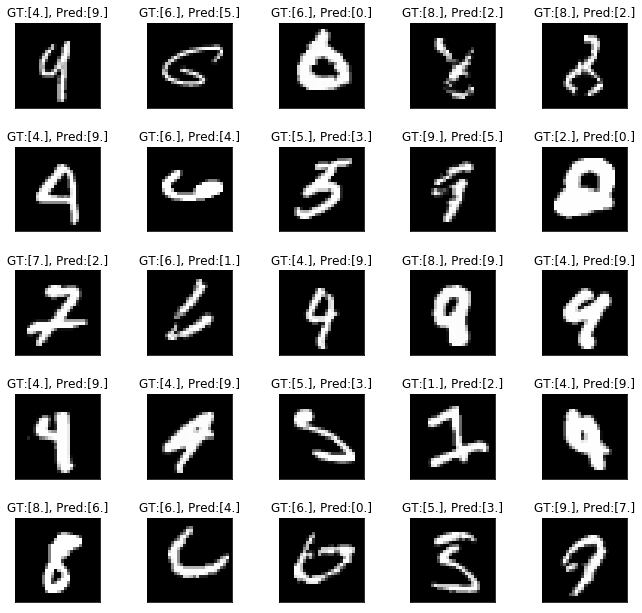

In [26]:
num_img_rows = 5
num_img_cols = 5

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(my_misclassified_images[i,:,:], cmap='gray', interpolation='none')
  plt.title("GT:{}, Pred:{}".format(ground_truth[i].numpy(), classified_lie[i].numpy()))
  plt.xticks([])
  plt.yticks([])

## Both L1 and L2 Regularization

In [27]:
from torch.optim.lr_scheduler import StepLR

model_4 =  Net().to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000005)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_4, device, train_loader, optimizer, epoch, l1=True)
    # scheduler.step()
    test(model_4, device, test_loader, num=3)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.1866173893213272 Batch_id=468 Accuracy=85.87: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0837, Accuracy: 9789/10000 (97.89%)

EPOCH: 1


Loss=0.10317646712064743 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0589, Accuracy: 9840/10000 (98.40%)

EPOCH: 2


Loss=0.159415602684021 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.08543240278959274 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.1354358196258545 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9864/10000 (98.64%)

EPOCH: 5


Loss=0.03567192703485489 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.08763144910335541 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.02870774269104004 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9898/10000 (98.98%)

EPOCH: 8


Loss=0.029284777119755745 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.06402041763067245 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9909/10000 (99.09%)

EPOCH: 10


Loss=0.08906630426645279 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 36.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.08903637528419495 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.016743915155529976 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.025425530970096588 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.05609794706106186 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:15<00:00, 29.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.03800708428025246 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9921/10000 (99.21%)

EPOCH: 16


Loss=0.03672057390213013 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.04176870360970497 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.02204626239836216 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.01557956263422966 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.0304263848811388 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.05538460984826088 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.08534994721412659 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Loss=0.05086848884820938 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


Loss=0.015078133903443813 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 25


Loss=0.03485264256596565 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 36.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9948/10000 (99.48%)

EPOCH: 26


Loss=0.01675952598452568 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9944/10000 (99.44%)

EPOCH: 27


Loss=0.04577033966779709 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.08735720813274384 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 30.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

EPOCH: 29


Loss=0.05170213803648949 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9939/10000 (99.39%)

EPOCH: 30


Loss=0.05070754513144493 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 31


Loss=0.025591295212507248 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 32


Loss=0.013395659625530243 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 33


Loss=0.08951055258512497 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9930/10000 (99.30%)

EPOCH: 34


Loss=0.006033957004547119 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9950/10000 (99.50%)

EPOCH: 35


Loss=0.012799032032489777 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 36


Loss=0.0609266571700573 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)

EPOCH: 37


Loss=0.020357947796583176 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 38


Loss=0.04636470973491669 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 39


Loss=0.029393061995506287 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s]



Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)



## Test loss of above four training models

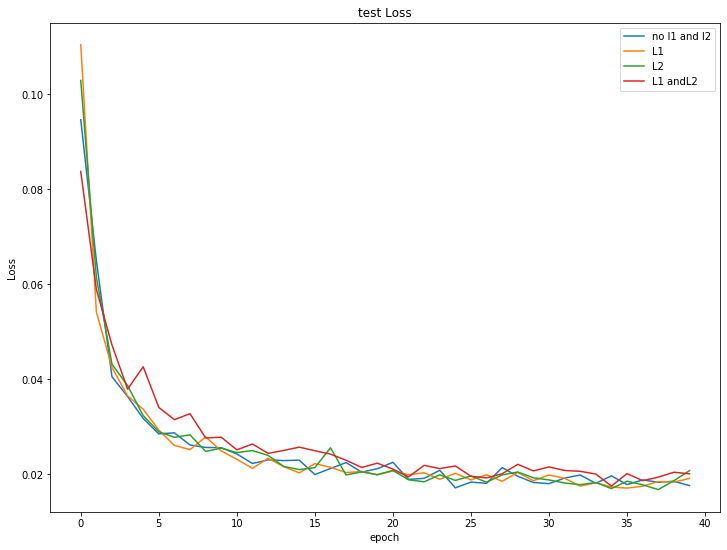

In [44]:
fig, axs = plt.subplots(1,1,figsize=(12,9))
plt.plot(test_losses[0])
plt.plot(test_losses[1])
plt.plot(test_losses[2])
plt.plot(test_losses[3])

plt.title('test Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['no l1 and l2', 'L1', 'L2', 'L1 andL2'], loc='best')
plt.show()

## Test accuracy of above four training models

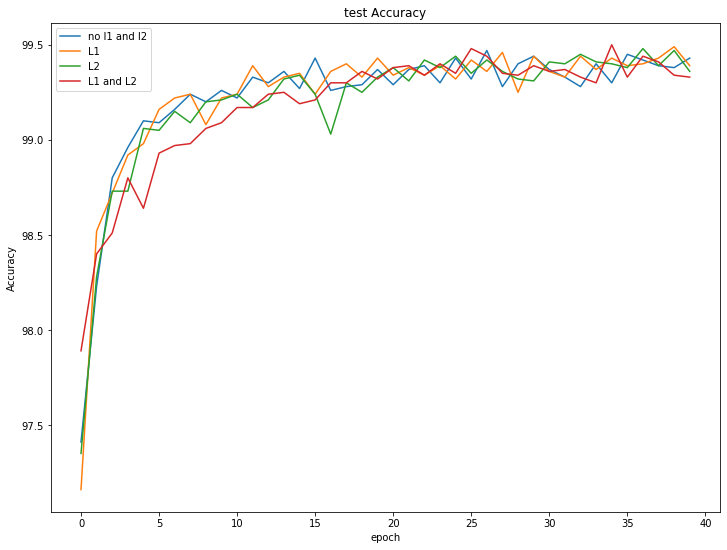

In [45]:
fig, axs = plt.subplots(1,1,figsize=(12,9))
plt.plot(test_acc[0])
plt.plot(test_acc[1])
plt.plot(test_acc[2])
plt.plot(test_acc[3])

plt.title('test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['no l1 and l2', 'L1', 'L2', 'L1 and L2'], loc='best')
plt.show()